## Project 2 IPYNB code (Eric Wong) 

## Imports

In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
from numbers import Number
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None 
%matplotlib inline

## Training and Test Merge to clean data
#####  -- TESTING DATA WILL BE SLICED OUT BEFORE TRAINING --

In [67]:
df = pd.read_csv('..//project-2//datasets//train.csv')
df.shape

(2051, 81)

In [68]:
dft = pd.read_csv('..//project-2//datasets//test.csv')
dft.shape
#missing price column

(879, 80)

In [69]:
df = df.append(dft)
df.shape

(2930, 81)

In [70]:
df.reset_index(inplace=True, drop=True)

In [71]:
#Column names to lowercase and no spaces
df.rename(columns= lambda x: x.replace(' ', '_'), inplace=True)
df.columns = df.columns.str.lower()

In [72]:
df.isnull().sum().head()

1st_flr_sf          0
2nd_flr_sf          0
3ssn_porch          0
alley            2732
bedroom_abvgr       0
dtype: int64

## Data Cleaning

In [73]:
# Data Cleaning of columns based on Documentation
#    If the column was a catergorial/string, we gave flags 1 for non-nan values.
#    If the column was continous and a value of 0 was justifiable (such as not having a basement), NaNs were replaced with 0.
#Arguably, we may not want to add nobasement data to basement data, however for larger correlative analysis it will provide a
#greater aggregate view.
#    If the column had documentatation which explained NA values, it was addressed accordingly.

In [74]:
# Lots Frontage -> Replace 0 for missing NaN
df['lot_frontage'] = [x if x >= 0 else 0 for x in df.lot_frontage]

In [75]:
#Alley NaN -> FillNA with NoAlley (No Alley)
df.alley.fillna('Noalley', inplace =True)

In [76]:
#Masonary Veneer -> 
df['mas_vnr_type'] = [x if x == str(x) else 'None' for x in df.mas_vnr_type]

In [77]:
#Masonary area - > FillNA with 0 (Rows with NA veneer are same as area. Imply No Veener == 0 area)
df['mas_vnr_area'].fillna('0', inplace =True)

In [78]:
#Basement Qualtiy -> FillNA with Nobase (No Basement)
df['bsmt_qual'] = [x if x == str(x) else 'Nobase' for x in df.bsmt_qual]

In [79]:
#Basement Condition - > FillNA with Nobase (No Basement)
df['bsmt_cond'] = [x if x == str(x) else 'Nobase' for x in df.bsmt_cond]

In [80]:
#Basement Exposure - > FillNA with Nobase (No Basement)
df['bsmt_exposure'] = [x if x == str(x) else 'Nobase' for x in df.bsmt_exposure]

In [81]:
#Basement Type 1 - > FillNA with Nobase (No Basement)
df['bsmtfin_type_1'] = [x if x == str(x) else 'Nobase' for x in df.bsmtfin_type_1]

In [82]:
#Basement type1 finished sqft - > FillNA with 0 (Checked out and says No Basement)
df[df.bsmtfin_sf_1.isnull() == True]['bsmtfin_type_1']
df['bsmtfin_sf_1'].fillna('0', inplace =True)

In [83]:
#Basement Type 2 - > FillNA with Nobase (No Basement)
df['bsmtfin_type_2'] = [x if x == str(x) else 'Nobase' for x in df.bsmtfin_type_2]

In [84]:
#Basement type2 finished sqft - > FillNA with 0 (Checked out and says  No Basement)
df[df.bsmtfin_sf_2.isnull() == True]['bsmtfin_type_2']
df['bsmtfin_sf_2'].fillna('0', inplace =True)

In [85]:
#Basement unfinished sqft - > FillNA with 0 (Checked out and says No Basement)
df[df.bsmt_unf_sf.isnull() == True]['bsmt_qual']
df['bsmt_unf_sf'].fillna('0', inplace =True)

In [86]:
#Total Basement Sq.Ft - > FillNA with 0 (Checked out and says No Basement)
df[df.total_bsmt_sf.isnull() == True]['total_bsmt_sf']
df['total_bsmt_sf'].fillna('0', inplace =True)

In [87]:
#Fireplace Quality - > FillNA with Nofp (No Fireplace)
df['fireplace_qu'] = [x if x == str(x) else 'Nofp' for x in df.fireplace_qu]

In [88]:
#Garage Type -> Fillna Nog(No garage)
df.garage_type.fillna('Nog', inplace = True)

In [89]:
#Garage finish - > FillNA Nog (No garage)
df.garage_finish.fillna('Nog', inplace=True)

In [90]:
# Number of cars garage can fit -> FillNA 
df.garage_cars.fillna(0, inplace =True)

In [91]:
# Size of garage -> FillNA
df.garage_area.fillna(0, inplace=True)

In [92]:
#Garage Quality - > FillNA Nog (No garage)
df.garage_qual.fillna('Nog', inplace=True)

In [93]:
#Garage Condition -> FillNa Nog (No Garage)
df.garage_cond.fillna('Nog', inplace=True)

In [94]:
#Pool Quality -> Fillna NP (No Pool)
df.pool_qc.fillna('NP', inplace=True)

In [95]:
#Fence -> FillNA NF (No Fence)
df.fence.fillna('NF', inplace=True)

## Setting correct data type

In [96]:
# Setting appropriate column type
df = df.apply(pd.to_numeric, errors='ignore', axis=1)

In [97]:
df.mas_vnr_area = [int(x) for x in df.mas_vnr_area]
df.bsmtfin_sf_1 = [int(x) for x in df.bsmtfin_sf_1]
df.bsmtfin_sf_2 = [int(x) for x in df.bsmtfin_sf_2]
df.bsmt_unf_sf = [int(x) for x in df.bsmt_unf_sf]
df.total_bsmt_sf = [int(x) for x in df.total_bsmt_sf]

## Split Train and Testing again as to not affect index from dropping 

In [98]:
Xdata = df[0:2051]
Tdata = df[2051:]
Tdata.shape

(879, 81)

In [99]:
Xdata['exter_qual'].value_counts()/ len(Xdata['exter_qual'])

TA    0.607996
Gd    0.339834
Ex    0.039493
Fa    0.012677
Name: exter_qual, dtype: float64

In [100]:
Xdata.isnull().sum()[Xdata.isnull().sum() != 0]

bsmt_full_bath       2
bsmt_half_bath       2
garage_yr_blt      114
misc_feature      1986
dtype: int64

In [101]:
#bsmt_full_bath -> Drop rows
#bsmt_half_bath -> Drop rows
#garage_yr_blt -> Remove from features
#misc_feature -> Remove from features

## Dropping  small NULL values from Training set

In [102]:
#Dropping from Xdata bsmt_full_bath, bsmt_half_bath
Xdata.dropna(subset = ['bsmt_full_bath'], inplace = True)
Xdata.dropna(subset = ['bsmt_half_bath'], inplace = True)

## Fixing NULL value from Testing set

In [103]:
Tdata.isnull().sum()[Tdata.isnull().sum() != 0]

electrical         1
garage_yr_blt     45
misc_feature     838
saleprice        879
dtype: int64

In [104]:
#electrical is one data point. I wouldn't normall put false info but will fill with SKbrkr as most common datapoint
#saleprice will be dropped from Test Data
#garage_yr_blt -> Remove from features
#misc_feature -> Remove from features

In [105]:
Tdata['electrical'].isnull()[Tdata.electrical.isnull()]
#Tdata electrical loc is 2686 NOT actual index
Tdata['electrical'].value_counts()

SBrkr    814
FuseA     48
FuseF     15
FuseP      1
Name: electrical, dtype: int64

In [106]:
# Used most common value. Unlikely to skew data
Tdata['electrical'] = Tdata['electrical'].fillna('SBrkr')

In [107]:
Tdata = Tdata.drop('saleprice', axis=1)
Tdata.isnull().sum()[Tdata.isnull().sum() != 0]

garage_yr_blt     45
misc_feature     838
dtype: int64

In [108]:
#Resetting Tdata Index
Tdata.reset_index(inplace=True, drop=True)

## Dummy Variables 

In [109]:
# Getting dummies for catergorial values 
dummylist=[]
for x in range(0, len(Tdata.columns)):
    if Tdata.dtypes[x] == object:
        dummylist.append(Tdata.columns[x])

In [110]:
Xdata = pd.get_dummies(Xdata, columns=dummylist, drop_first=True)

In [111]:
Tdata = pd.get_dummies(Tdata, columns=dummylist, drop_first=True)

## Feature Selection/EDA

In [112]:
features = list(set(Xdata.columns).intersection(Tdata.columns))
features.append('saleprice')
features.remove('garage_yr_blt')

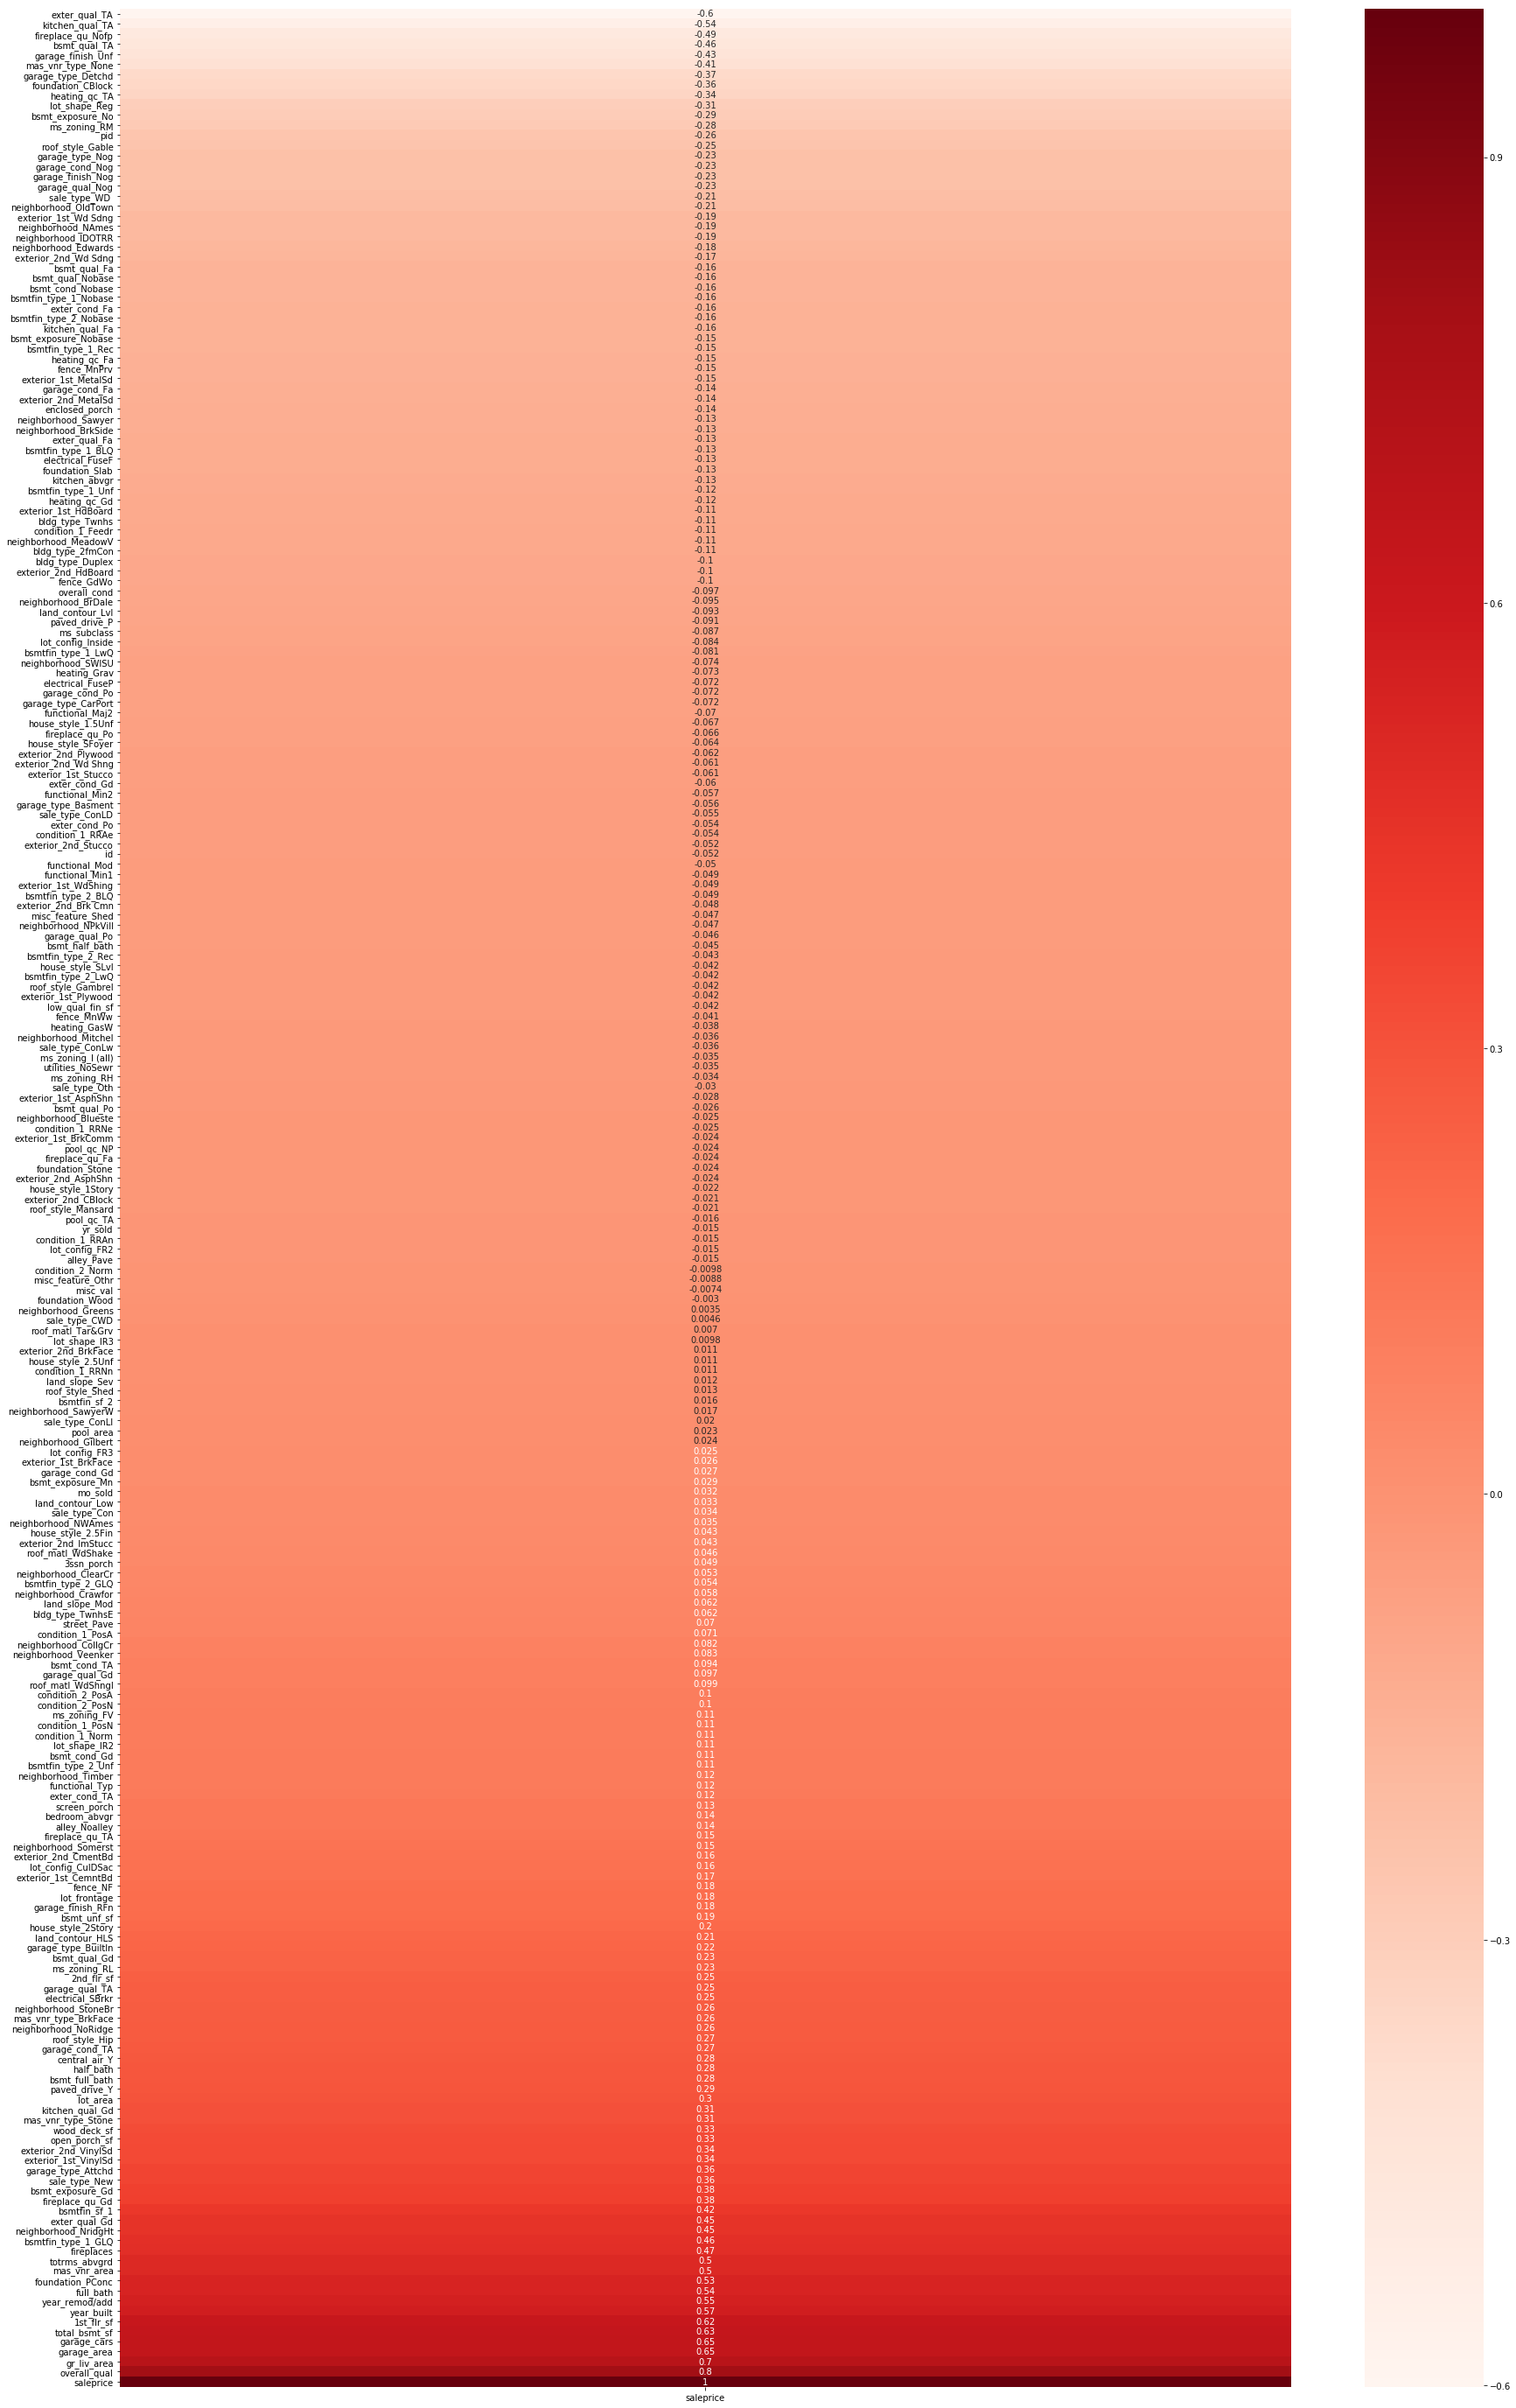

In [113]:
plt.figure(figsize=(30,50))
sns.heatmap(Xdata[features].corr()[['saleprice']].sort_values('saleprice'), cmap='Reds', annot=True)

In [114]:
##Revised Featrues based on correlation and variables greater than 20% correlation to sales price.
features = [x for x in features if (abs(Xdata[x].corr(Xdata['saleprice'])) >= .4)]

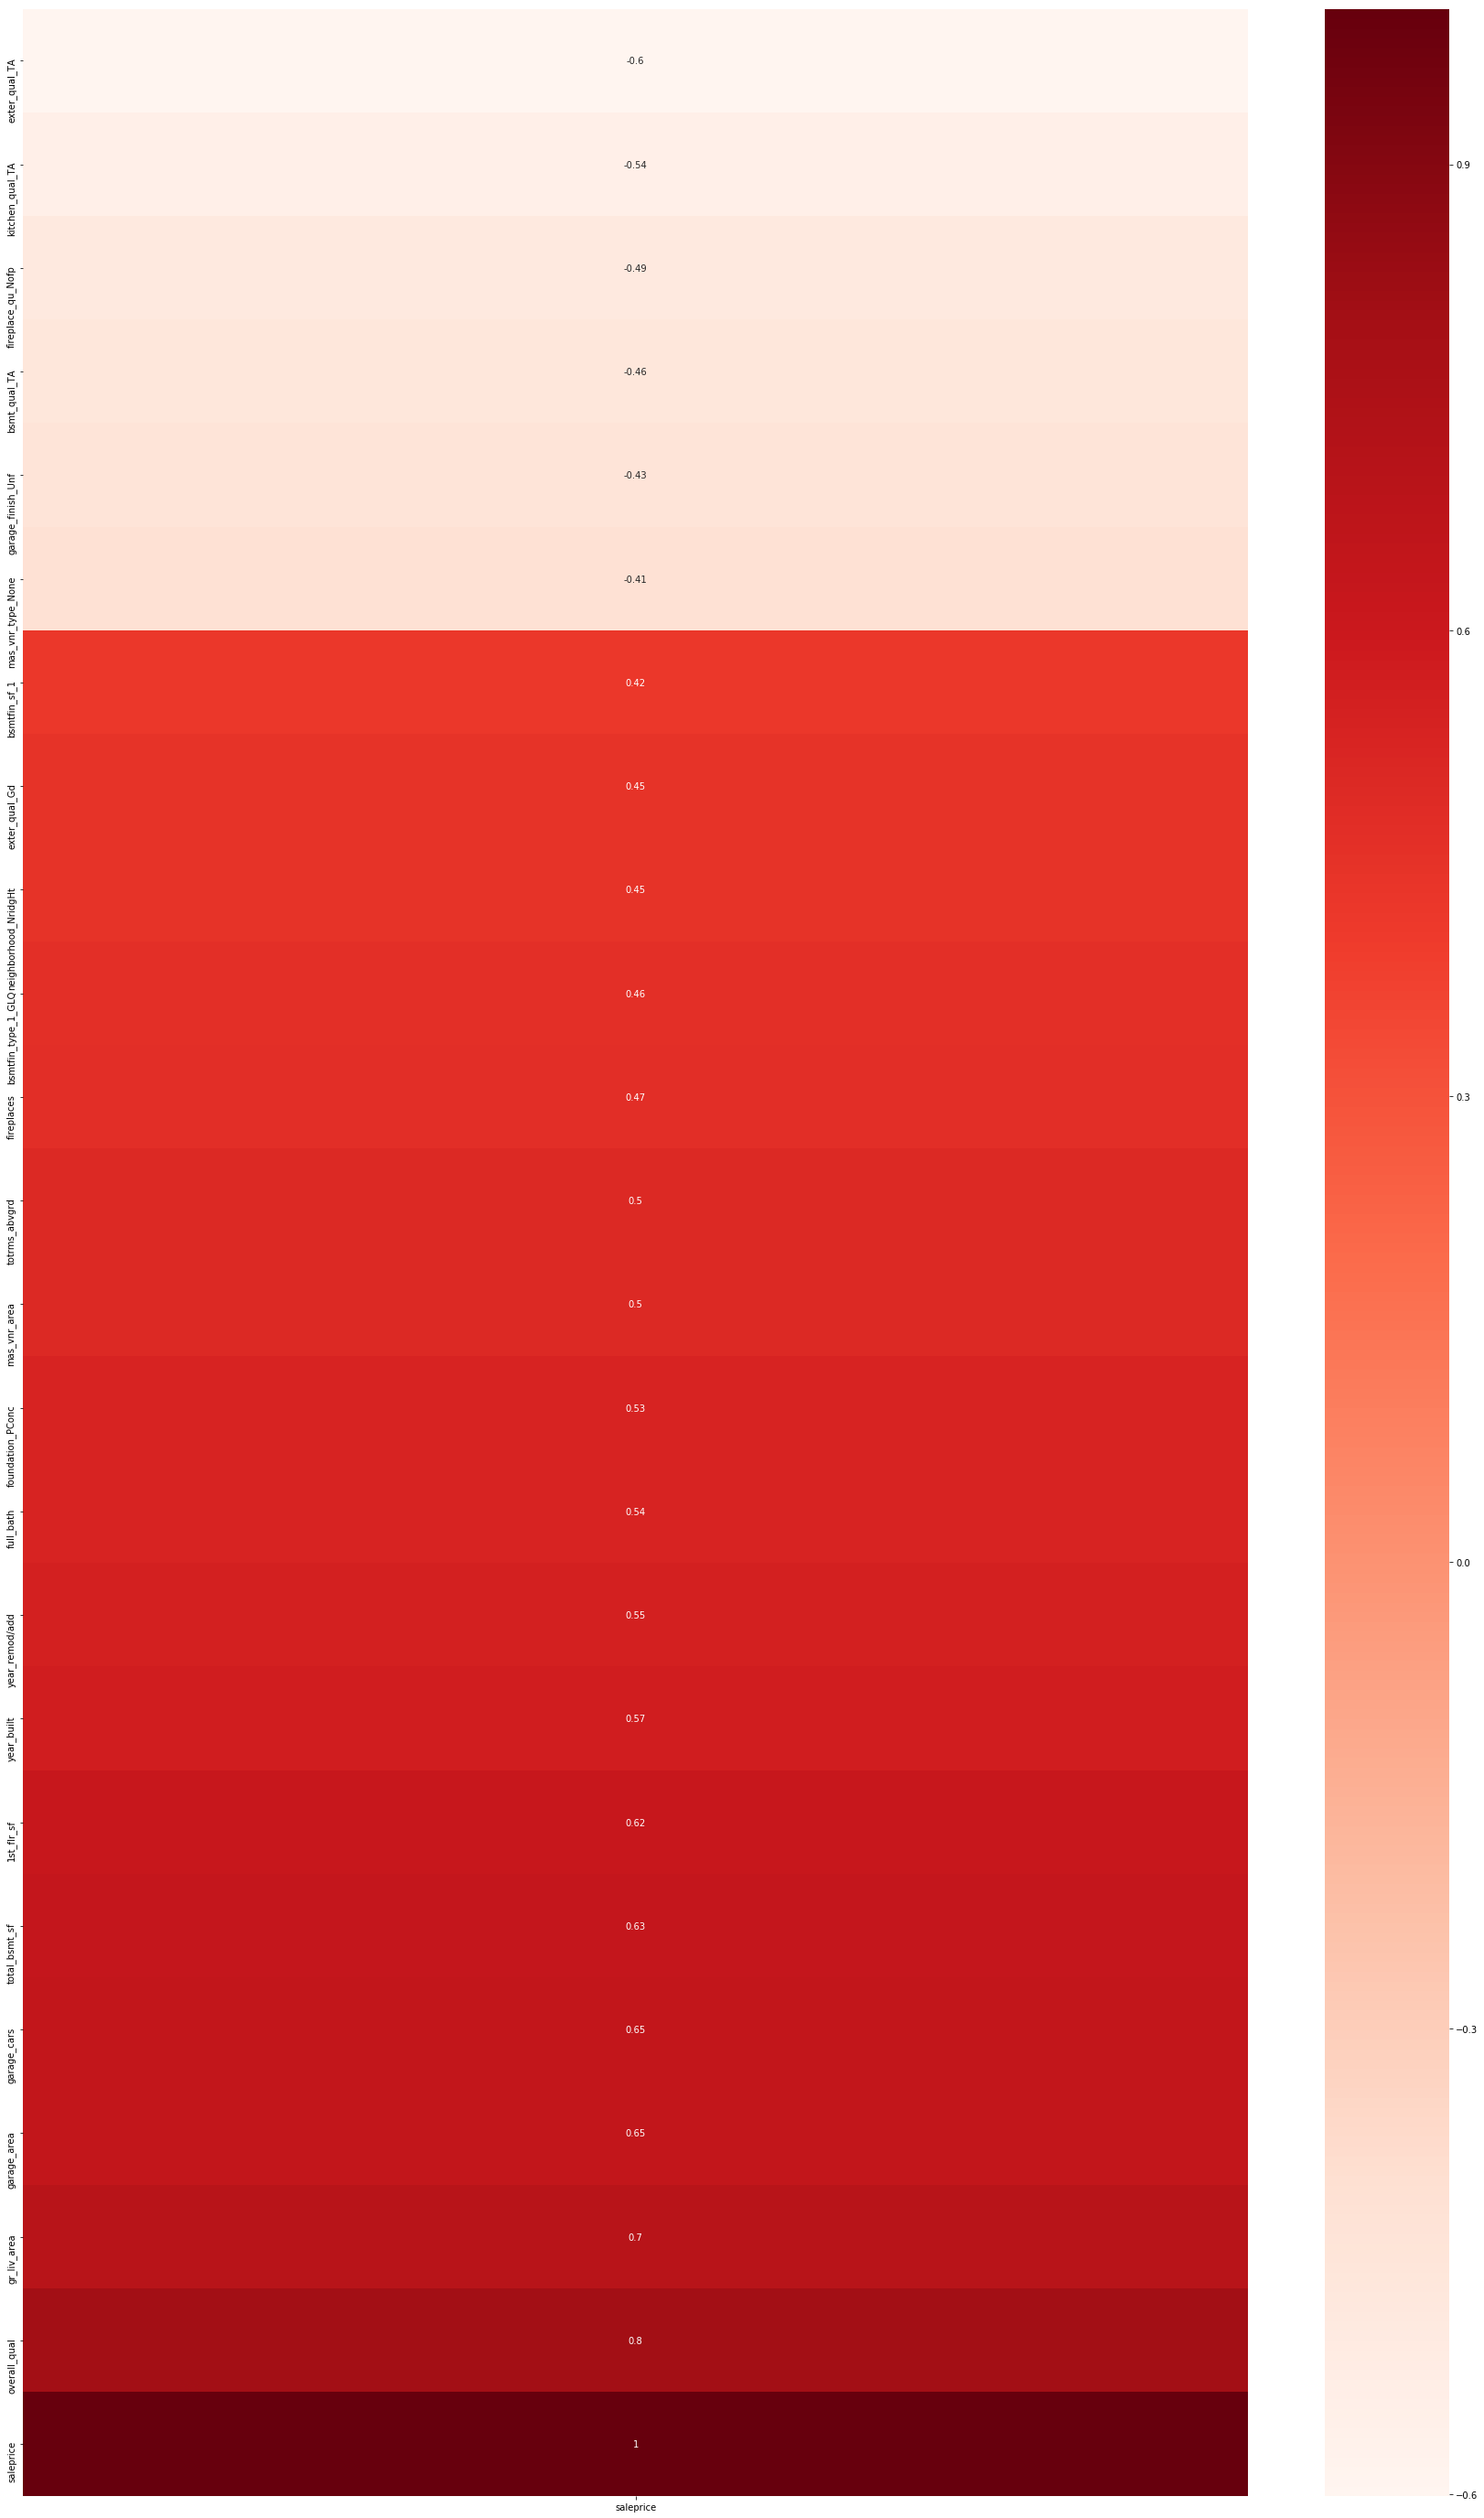

In [115]:
plt.figure(figsize=(30,50))
sns.heatmap(Xdata[features].corr()[['saleprice']].sort_values('saleprice'), cmap='Reds', annot=True)

In [116]:
#Features list
FeaturesList = features
FeaturesList.sort()
print(FeaturesList)

['1st_flr_sf', 'bsmt_qual_TA', 'bsmtfin_sf_1', 'bsmtfin_type_1_GLQ', 'exter_qual_Gd', 'exter_qual_TA', 'fireplace_qu_Nofp', 'fireplaces', 'foundation_PConc', 'full_bath', 'garage_area', 'garage_cars', 'garage_finish_Unf', 'gr_liv_area', 'kitchen_qual_TA', 'mas_vnr_area', 'mas_vnr_type_None', 'neighborhood_NridgHt', 'overall_qual', 'saleprice', 'total_bsmt_sf', 'totrms_abvgrd', 'year_built', 'year_remod/add']


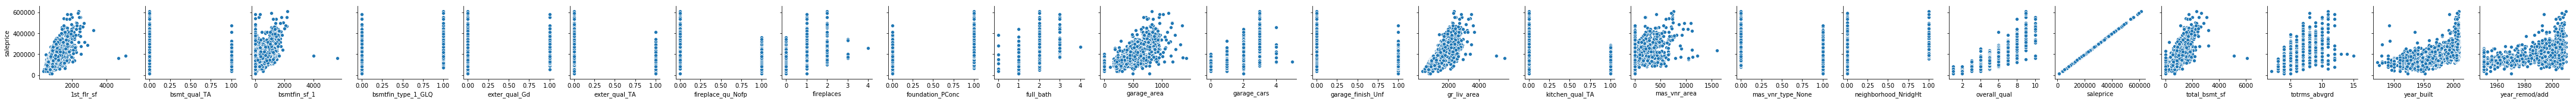

In [117]:
sns.pairplot(data= Xdata,  y_vars = ['saleprice'], x_vars=FeaturesList);

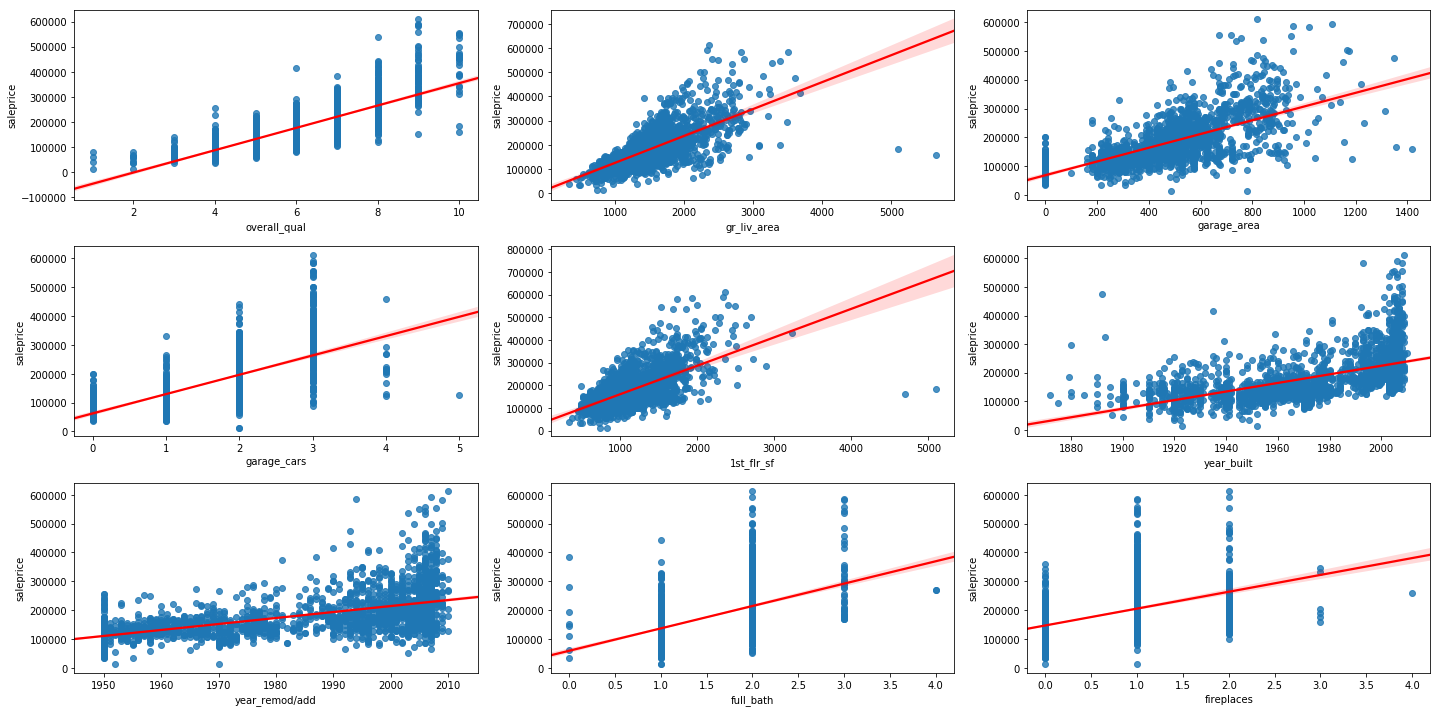

In [118]:
#Data with high correlative % with SalePrice (Positive)
f, axes = plt.subplots(3,3, figsize =(20,10))
plt.subplot(3,3,1)
sns.regplot(Xdata.overall_qual, Xdata.saleprice, line_kws={'color':'red'})
plt.subplot(3,3,2)
sns.regplot(Xdata.gr_liv_area, Xdata.saleprice, line_kws={'color':'red'})
plt.subplot(3,3,3)
sns.regplot(Xdata.garage_area, Xdata.saleprice, line_kws={'color':'red'})
plt.subplot(3,3,4)
sns.regplot(Xdata.garage_cars, Xdata.saleprice, line_kws={'color':'red'})
plt.subplot(3,3,5)
sns.regplot(Xdata['1st_flr_sf'], Xdata.saleprice, line_kws={'color':'red'})
plt.subplot(3,3,6)
sns.regplot(Xdata.year_built, Xdata.saleprice, line_kws={'color':'red'})
plt.subplot(3,3,7)
sns.regplot(Xdata['year_remod/add'], Xdata.saleprice, line_kws={'color':'red'})
plt.subplot(3,3,8)
sns.regplot(Xdata.full_bath, Xdata.saleprice, line_kws={'color':'red'})
plt.subplot(3,3,9)
sns.regplot(Xdata.fireplaces, Xdata.saleprice, line_kws={'color':'red'})
plt.tight_layout()

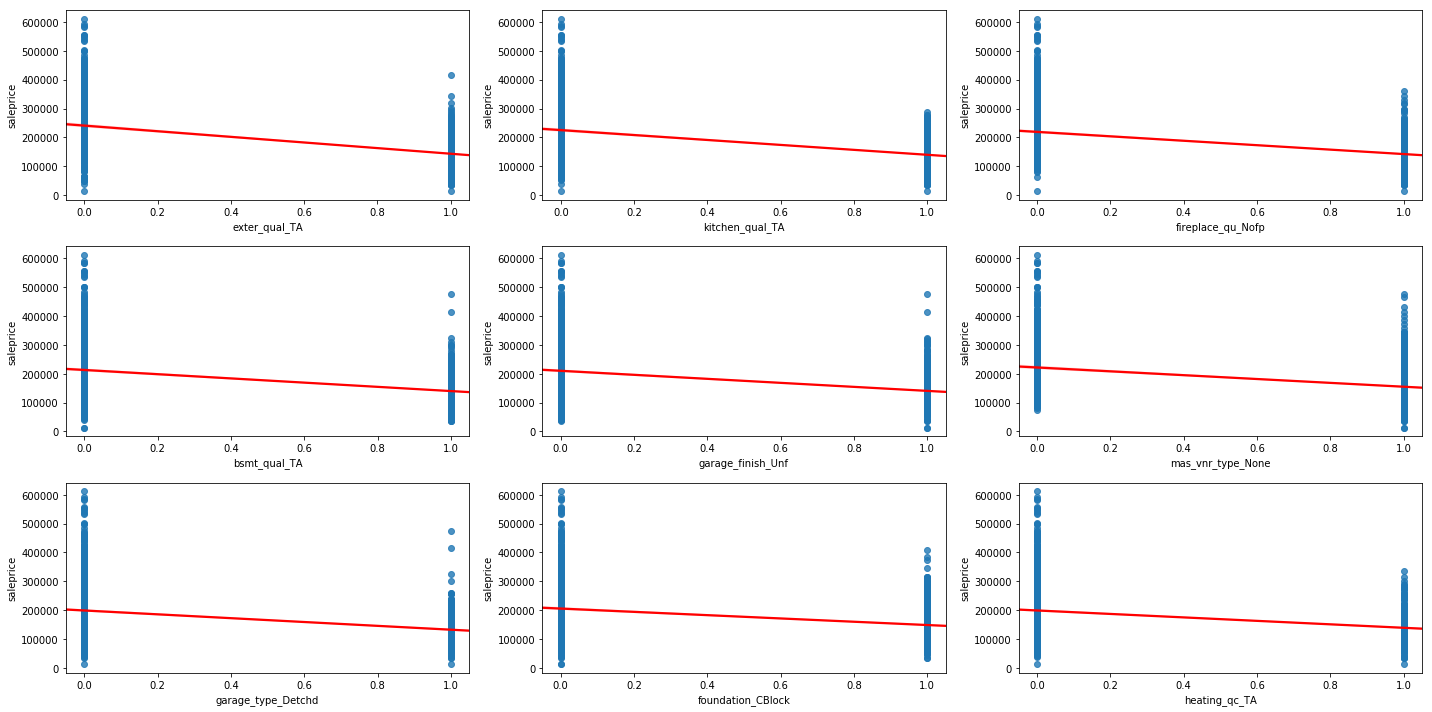

In [119]:
#Data with high correlative % with SalePrice (Negative)
f, axes = plt.subplots(3,3, figsize =(20,10))
plt.subplot(3,3,1)
sns.regplot(Xdata.exter_qual_TA, Xdata.saleprice, line_kws={'color':'red'})
plt.subplot(3,3,2)
sns.regplot(Xdata.kitchen_qual_TA, Xdata.saleprice, line_kws={'color':'red'})
plt.subplot(3,3,3)
sns.regplot(Xdata.fireplace_qu_Nofp, Xdata.saleprice, line_kws={'color':'red'})
plt.subplot(3,3,4)
sns.regplot(Xdata.bsmt_qual_TA, Xdata.saleprice, line_kws={'color':'red'})
plt.subplot(3,3,5)
sns.regplot(Xdata['garage_finish_Unf'], Xdata.saleprice, line_kws={'color':'red'})
plt.subplot(3,3,6)
sns.regplot(Xdata.mas_vnr_type_None, Xdata.saleprice, line_kws={'color':'red'})
plt.subplot(3,3,7)
sns.regplot(Xdata['garage_type_Detchd'], Xdata.saleprice, line_kws={'color':'red'})
plt.subplot(3,3,8)
sns.regplot(Xdata.foundation_CBlock, Xdata.saleprice, line_kws={'color':'red'})
plt.subplot(3,3,9)
sns.regplot(Xdata.heating_qc_TA, Xdata.saleprice, line_kws={'color':'red'})
plt.tight_layout()

In [120]:
y = Xdata['saleprice']

In [121]:
features.remove('saleprice')
X = Xdata[features]
T = Tdata[features]

## Standard Scaling

In [122]:
ss = StandardScaler()
ss.fit(X)
X_train = ss.transform(X)
X_test = ss.transform(T)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


## Model Building

In [123]:
lr = LinearRegression()
lr.fit(X_train, y)
lrpred = lr.predict(X_test)

In [124]:
lrdata = pd.DataFrame(lrpred)
lrdata.columns = ['SalePrice']
lrdata.head()
indexid = pd.DataFrame(Tdata.id)
Sub = pd.merge(lrdata, indexid, left_index=True, right_index=True)
Sub = pd.DataFrame(Sub)
Sub = Sub[['id', 'SalePrice']]
Sub.columns = ['Id', 'SalePrice']

In [125]:
Sub.to_csv('P2EW.csv', index=False)

## Scoring Model (RMSE)
#### Scoring model to train data, not the testing data

In [126]:
#Fitting regres
lr = LinearRegression()
lr.fit(X_train, y)
lrpred = lr.predict(X_train)
FS = np.sqrt(mean_squared_error(y, lrpred ))
print('Root Mean Square Error of ',  round(FS,2))

Root Mean Square Error of  32579.94
